<a href="https://colab.research.google.com/github/andrediasn/Analise_ECOS-TCC/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicialização

In [1]:
#@title Bibliotecas
# Importações
from difflib import SequenceMatcher
from IPython.display import HTML, display
import requests
import time
import base64
import json
import datetime
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from getpass import getpass
from tabulate import tabulate

In [2]:
#@title Dados de login
# Codificando o nome de usuário e a senha em Base64
username = "andre.dias"
password = getpass('Password:')

KeyboardInterrupt: Interrupted by user

In [ ]:
#@title Funções da inicialização
# Chamada de api do sydle
def requestSydle(method, payload):
    # URL para onde será feita a requisição POST
    switch = {
        "deleteData": "https://sumicity-dev.sydle.one/api/1/main/testAES/AesSettings/resetObjects",
        "getAesSettings": "https://sumicity-dev.sydle.one/api/1/main/testAES/AesSettings/_get",
        "getClassLogs": "https://sumicity-dev.sydle.one/api/1/main/testAES/AesSettings/getClassLogs",
        "getUserStats": "https://sumicity-dev.sydle.one/api/1/main/testAES/UserStats/_search",
        "createUserStats": "https://sumicity-dev.sydle.one/api/1/main/testAES/UserStats/_create",
        "updateUserStats": "https://sumicity-dev.sydle.one/api/1/main/testAES/UserStats/_patch",
        "getSectorStats": "https://sumicity-dev.sydle.one/api/1/main/testAES/SectorStats/_search",
        "createSectorStats": "https://sumicity-dev.sydle.one/api/1/main/testAES/SectorStats/_create",
        "updateSectorStats": "https://sumicity-dev.sydle.one/api/1/main/testAES/SectorStats/_patch"
    }
    url = switch.get(method)
    credentials = f"{username}:{password}"
    base64_credentials = base64.b64encode(credentials.encode()).decode()
    # Cabeçalhos da requisição, incluindo a autenticação básica
    headers = {
        "Authorization": f"Basic {base64_credentials}",
        "Content-Type": "application/json"
    }
    # Fazendo a requisição POST
    response = requests.post(url, json=payload, headers=headers)
    # Verificando o status da resposta
    if response.status_code == 200:
        return response.json()
    else:
        print("Erro na requisição:", response.status_code)
        raise Exception(response.text)

# Valida dados de configuração
def validateInput():
    if not AesSettings["sectorConfig"] or len(AesSettings["sectorConfig"]) == 0:
        raise Exception("Necessário informar a Configuração de Setor")
    if not AesSettings["referencePeriod"]:
        raise Exception("Necessário informar o Período de referência")
    if not AesSettings["decayFactor"]:
        raise Exception("Necessário informar o Fator de decaimento")
    #Verifica se há classes repetidas nos setores
    if AesSettings["sectorConfig"] and len(AesSettings["sectorConfig"]) > 0:
        checkedIds = []
        for sector in AesSettings["sectorConfig"]:
            for classId in sector["classIds"]:
                if classId in checkedIds and classId != "6450fa8c51e06f64c7f1464a":
                    raise Exception(f"Classe repetida: {classId} setor: {sector['sector']}")
                checkedIds.append(classId)

def progress(value, max=100):
    k =  value*100/max
    return HTML("""
        <p>{k}% ({value}/{max})</p>
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max, k = k))

In [ ]:
#@title Inicialização das variaveis
#Constantes sydle
AES_SETTINGS_OBJECT_ID = "6492886a08919a4b171f22c0"

#Declarações globais
totalSystemClass = 0
sectorLogs = []
logsHistory = []
usersLogs = []
globalUsersLogs = []
# Configurações pré-definidas
AesSettings = requestSydle("getAesSettings", { "_id": AES_SETTINGS_OBJECT_ID })
# Valida as configurações
validateInput()
# Deleta os dados salvos anteriormente
requestSydle("deleteData", { "confirm": "yes"})


{}

# Coleta de Dados

In [ ]:
#@title Algorítimos de distância
# Inutilizado devido ao tempo de processamento
def getLevenshteinDistance(log1, log2):
    inicio = time.time()
    m = len(log1)
    n = len(log2)
    dp = [[0] * (n + 1) for _ in range(m + 1)] # Criar uma matriz para armazenar os cálculos intermediários
    # Inicializar os valores base
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    # Calcular a distância de Levenshtein
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if log1[i - 1] == log2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])
    fim = time.time()
    # print("Tempo de execução: ", fim - inicio, "segundos")
    return dp[m][n]

# Calculo da distância de Levenshtein com auxilio da biblioteca difflib
def getDifflibSequenceMatcher(log1, log2):
    inicio = time.time()
    # Calculando as operações necessárias para transformar a string1 na string2
    diferencas = SequenceMatcher(None, log1, log2).get_opcodes()
    # Contadores para as operações
    adicoes = 0
    remocoes = 0
    alteracoes = 0
    # Iterando pelas diferenças
    for tag, i1, i2, j1, j2 in diferencas:
        if tag == 'insert':
            adicoes += (j2 - j1)
        elif tag == 'delete':
            remocoes += (i2 - i1)
        elif tag == 'replace':
            alteracoes += min(i2 - i1, j2 - j1)
    total = adicoes + remocoes + alteracoes
    fim = time.time()
    # print("Tempo: ", fim - inicio, " segundos")
    return total

In [ ]:
#@title Funções principais
# Calula a contribuição em cada log
def getUsersLogs(classLogs):
    global totalSystemClass
    if classLogs["success"] == True:
        hasClassLogs = classLogs["logs"] and len(classLogs["logs"]) > 0
        indexUser = None
        lastMethods = []
        contribution = {}

        if hasClassLogs:
            for indexLog, log in enumerate(classLogs["logs"]):
                arrayLogMethods = list(log["methods"].values())

                if indexLog == 0:
                    contribution = getContribution(log["date"], arrayLogMethods)
                else:
                    contribution = getContribution(log["date"], arrayLogMethods, lastMethods)

                # Dados de usuário para o setor
                indexUser = next((index for index, user in enumerate(usersLogs) if user["userId"] == log["_user"]["_id"]), -1)
                if indexUser == -1:
                    usersLogs.append({
                        "userId": log["_user"]["_id"],
                        "logs": 1,
                        "contributionTotal": contribution["total"],
                        "contributionPeriod": contribution["period"],
                        "contributionFactor": contribution["factor"]
                    })
                else:
                    usersLogs[indexUser]["logs"] += 1
                    usersLogs[indexUser]["contributionTotal"] += contribution["total"]
                    usersLogs[indexUser]["contributionPeriod"] += contribution["period"]
                    usersLogs[indexUser]["contributionFactor"] += contribution["factor"]

                # Dados de usuario para o projeto
                indexGlobalUser = next((index for index, user in enumerate(globalUsersLogs) if user["userId"] == log["_user"]["_id"]), -1)
                if indexGlobalUser == -1:
                    globalUsersLogs.append({
                        "userId": log["_user"]["_id"],
                        "logs": 1,
                        "contributionTotal": contribution["total"],
                        "contributionPeriod": contribution["period"],
                        "contributionPeriod2": contribution["period2"],
                        "contributionFactor": contribution["factor"],
                    })
                    logsHistory.append({
                        "userId": log["_user"]["_id"],
                        "logsHistory": [{
                            "timeDiff": contribution["timeDiff"],
                            "classId": classLogs["class"]["_id"],
                            "contributionTotal": contribution["total"],
                            "contributionPeriod": contribution["period"],
                            "contributionPeriod2": contribution["period2"],
                            "contributionFactor": contribution["factor"]
                        }]
                    })
                else:
                    globalUsersLogs[indexGlobalUser]["logs"] += 1
                    globalUsersLogs[indexGlobalUser]["contributionTotal"] += contribution["total"]
                    globalUsersLogs[indexGlobalUser]["contributionPeriod"] += contribution["period"]
                    globalUsersLogs[indexGlobalUser]["contributionPeriod2"] += contribution["period2"]
                    globalUsersLogs[indexGlobalUser]["contributionFactor"] += contribution["factor"]
                    logsHistory[indexGlobalUser]["logsHistory"].append({
                        "timeDiff": contribution["timeDiff"],
                        "classId": classLogs["class"]["_id"],
                        "contributionTotal": contribution["total"],
                        "contributionPeriod": contribution["period"],
                        "contributionPeriod2": contribution["period2"],
                        "contributionFactor": contribution["factor"]
                    })

                lastMethods = arrayLogMethods

        if classLogs["class"]["_creationUser"]["_id"] != "System":
            arrayClassMethods = list(classLogs["class"]["methods"].values())
            if hasClassLogs and len(lastMethods) > 0:
                contribution = getContribution(classLogs["class"]["date"], arrayClassMethods)
            else:
                contribution = getContribution(classLogs["class"]["date"], arrayClassMethods, lastMethods)

            indexUser = next((index for index, user in enumerate(usersLogs) if user["userId"] == classLogs["class"]["_creationUser"]["_id"]), -1)

            if indexUser == -1:
                usersLogs.append({
                    "userId": classLogs["class"]["_creationUser"]["_id"],
                    "logs": 1,
                    "contributionTotal": contribution["total"],
                    "contributionPeriod": contribution["period"],
                    "contributionPeriod2": contribution["period2"],
                    "contributionFactor": contribution["factor"]
                })
            else:
                usersLogs[indexUser]["logs"] += 1
                usersLogs[indexUser]["contributionTotal"] += contribution["total"]
                usersLogs[indexUser]["contributionPeriod"] += contribution["period"]
                usersLogs[indexUser]["contributionFactor"] += contribution["factor"]

            indexGlobalUser = next((index for index, user in enumerate(globalUsersLogs) if user["userId"] == classLogs["class"]["_creationUser"]["_id"]), -1)

            if indexGlobalUser == -1:
                globalUsersLogs.append({
                    "userId": classLogs["class"]["_creationUser"]["_id"],
                    "logs": 1,
                    "contributionTotal": contribution["total"],
                    "contributionPeriod": contribution["period"],
                    "contributionPeriod2": contribution["period2"],
                    "contributionFactor": contribution["factor"],
                })
                logsHistory.append({
                    "userId": classLogs["class"]["_creationUser"]["_id"],
                    "logsHistory": [{
                        "timeDiff": contribution["timeDiff"],
                        "classId": classLogs["class"]["_id"],
                        "contributionTotal": contribution["total"],
                        "contributionPeriod": contribution["period"],
                        "contributionPeriod2": contribution["period2"],
                        "contributionFactor": contribution["factor"]
                    }]
                })
            else:
                globalUsersLogs[indexGlobalUser]["logs"] += 1
                globalUsersLogs[indexGlobalUser]["contributionTotal"] += contribution["total"]
                globalUsersLogs[indexGlobalUser]["contributionPeriod"] += contribution["period"]
                globalUsersLogs[indexGlobalUser]["contributionPeriod2"] += contribution["period2"]
                globalUsersLogs[indexGlobalUser]["contributionFactor"] += contribution["factor"]
                logsHistory[indexGlobalUser]["logsHistory"].append({
                    "timeDiff": contribution["timeDiff"],
                    "classId": classLogs["class"]["_id"],
                    "contributionTotal": contribution["total"],
                    "contributionPeriod": contribution["period"],
                    "contributionPeriod2": contribution["period2"],
                    "contributionFactor": contribution["factor"]
                })

    elif classLogs["message"] == "SystemClass":
        totalSystemClass += 1
    else:
        raise Exception(classId)

# Calcula contribuição do colaborador entre logs
def getContribution(dateLog, newLog, oldLog=None):
    contribution = {
        "total": 0,
        "period": 0,
        "period2": 0,
        "factor": 0,
        "timeDiff": 0
    }

    if newLog and len(newLog) > 0:
        if oldLog and len(oldLog) > 0:
            for method in newLog:
                if method["scripts"] and method["scripts"][0] is not None:
                    old_method = next((old for old in oldLog if old["identifier"] == method["identifier"]), None)
                    if old_method and old_method["scripts"][0] is not None:
                        contribution["total"] += getDifflibSequenceMatcher("".join(old_method["scripts"]), "".join(method["scripts"]))
                    else:
                        contribution["total"] += len("".join(method["scripts"]))
        else:
            for method in newLog:
                if method["scripts"] and method["scripts"][0] is not None:
                    contribution["total"] += len("".join(method["scripts"]))

    contribution["total"] += 1

    # Calula diferença de dias
    currentDate = datetime.datetime.now().date()
    logDate = datetime.datetime.strptime(dateLog.split('T')[0], "%Y-%m-%d").date()
    diff = currentDate - logDate
    contribution["timeDiff"] = diff.days

    # Calula o decaimento temporal
    contribution["period"] = int(contribution["total"] * (1 - (contribution["timeDiff"] / AesSettings["referencePeriod"])))
    contribution["period2"] = int(contribution["total"] * (1 - (contribution["timeDiff"] / 90)))
    contribution["factor"] = int(contribution["total"] * math.exp(-AesSettings["decayFactor"] * contribution["timeDiff"]))

    return contribution

In [ ]:
# Salva os resultados coletados no SYDLE
def updateDatabaseObject(sectorLog):
    time.sleep(0.2)
    payload = {
        "query": {
            "term": {
                "sector.keyword": sectorLog["sector"]
            }
        }
    }
    objectSectorStats = requestSydle("getSectorStats", payload)
    if objectSectorStats["hits"]["total"] > 0:
        payload = {
            "_id": objectSectorStats["hits"]["hits"][0]["_source"]['_id'],
            "_operationsList": [{
                "op": "replace",
                "path": "userLogs",
                "value": sectorLog['userLogs']
            }]
        }
        requestSydle("updateSectorStats", payload)
    else:
        requestSydle("createSectorStats", sectorLog)

    for user in sectorLog["userLogs"]:
        time.sleep(0.2)
        payload = {
            "query": {
                "term": {
                    "user._id": user["userId"]
                }
            }
        }
        objectUserStats = requestSydle("getUserStats", payload)
        if objectUserStats["hits"]["total"] > 0:
            indexSector = next((i for i, sl in enumerate(objectUserStats["hits"]["hits"][0]["_source"]['sectorLogs']) if sl['sector'] == sector), -1)
            if indexSector != -1:
                objectUserStats["hits"]["hits"][0]["_source"]['sectorLogs'][indexSector]['logs'] = user['logs']
                objectUserStats["hits"]["hits"][0]["_source"]['sectorLogs'][indexSector]['contributionTotal'] = user['contributionTotal']
                objectUserStats["hits"]["hits"][0]["_source"]['sectorLogs'][indexSector]['contributionPeriod'] = user['contributionPeriod']
                objectUserStats["hits"]["hits"][0]["_source"]['sectorLogs'][indexSector]['contributionFactor'] = user['contributionFactor']
            else:
                objectUserStats["hits"]["hits"][0]["_source"]['sectorLogs'].append({
                    "sector": sectorLog["sector"],
                    "logs": user["logs"],
                    "contributionTotal": user["contributionTotal"],
                    "contributionPeriod": user["contributionPeriod"],
                    "contributionFactor": user["contributionFactor"]
                })
            payload = {
                "_id": objectUserStats["hits"]["hits"][0]["_source"]['_id'],
                "_operationsList": [{
                    "op": "replace",
                    "path": "sectorLogs",
                    "value": objectUserStats["hits"]["hits"][0]["_source"]['sectorLogs']
                }]
            }
            requestSydle("updateUserStats", payload)
        else:
            payload = {
                "user": user["userId"],
                "sectorLogs": {
                    "sector": sectorLog["sector"],
                    "logs": user["logs"],
                    "contributionTotal": user["contributionTotal"],
                    "contributionPeriod": user["contributionPeriod"],
                    "contributionFactor": user["contributionFactor"]
                }
            }
            requestSydle("createUserStats", payload)

In [ ]:
#@title Execução principal da coleta

# Itera cada setor
for indexSector, sector in enumerate(AesSettings["sectorConfig"]):
    out = display(progress(0, 100), display_id=True)

    print("Analisando: ", sector["sector"])
    # Itera cada classe do setor
    for index, classId in enumerate(sector["classIds"]):
        payload = {
            "classId": classId,
            "_source": True
        }
        # Obtém os logs da classe
        classLogs = requestSydle("getClassLogs", payload)
        time.sleep(0.2)
        # Calcula a contribuição
        getUsersLogs(classLogs)

        out.update(progress(index+1, len(sector["classIds"])))
    # Salva o resultado
    sectorLogs.append({
        "sector": sector["sector"],
        "userLogs": usersLogs.copy()
    })
    # Atualiza o banco de dados
    updateDatabaseObject(sectorLogs[indexSector])
    usersLogs = []

Analisando:  CRM


Analisando:  Billing


Analisando:  Integrador


# Análise dos dados

In [ ]:
#@title Normalização
# Realiza a normalização da contribuição
def normalize_objects(objects):
    max_value_obj = max(objects, key=lambda obj: obj['contributionTotal'])
    max_value = max_value_obj['contributionTotal']
    for obj in objects:
        if obj == max_value_obj:
            obj['normalizationTotal'] = 1
        else:
            obj['normalizationTotal'] = obj['contributionTotal'] / max_value
    max_value_obj = max(objects, key=lambda obj: obj['contributionPeriod'])
    max_value = max_value_obj['contributionPeriod']
    for obj in objects:
        if obj == max_value_obj:
            obj['normalizationPeriod'] = 1
        else:
            obj['normalizationPeriod'] = obj['contributionPeriod'] / max_value
    max_value_obj = max(objects, key=lambda obj: obj['contributionFactor'])
    max_value = max_value_obj['contributionFactor']
    for obj in objects:
        if obj == max_value_obj:
            obj['normalizationFactor'] = 1
        else:
            obj['normalizationFactor'] = obj['contributionFactor'] / max_value
    return objects

# Atualiza banco de dados
def updateStatsNormalized():
    listUserStats = requestSydle("getUserStats", {"size": 9999})

    if listUserStats["hits"]["total"] > 0:
        for userStat in listUserStats["hits"]["hits"]:
            time.sleep(0.2)
            normalize_objects(userStat["_source"]["sectorLogs"])
            payload = {
                "_id": userStat['_id'],
                "_operationsList": [{
                    "op": "replace",
                    "path": "sectorLogs",
                    "value": userStat["_source"]["sectorLogs"]
                }]
            }
            requestSydle("updateUserStats", payload)
    else:
        raise Exception("UserStats vazio")

    for sector in sectorLogs:
        time.sleep(0.2)
        if len(sector["userLogs"]) > 0:
            normalize_objects(sector["userLogs"])
            payload = {
                "query": {
                    "term": {
                        "sector.keyword": sector["sector"]
                    }
                }
            }
            objectSectorStats = requestSydle("getSectorStats", payload)
            if objectSectorStats ["hits"]["total"] > 0:
                payload = {
                    "_id": objectSectorStats["hits"]["hits"][0]["_source"]['_id'],
                    "_operationsList": [{
                        "op": "replace",
                        "path": "userLogs",
                        "value": sector["userLogs"]
                    }]
                }
                requestSydle("updateSectorStats", payload)
            else:
                raise Exception("SectorStats vazio")

updateStatsNormalized()

In [ ]:
#@title Tabela de Setorlogs
def print_sector_log_table(sectorLog):
    # Criação de listas para as colunas da tabela
    user_ids = []
    contribution_total = []
    contribution_period = []
    contribution_factor = []
    normalization_total = []
    normalization_period = []
    normalization_factor = []

    for log in sectorLog["userLogs"]:
        user_ids.append(log["userId"])
        contribution_total.append(log["contributionTotal"])
        contribution_period.append(log["contributionPeriod"])
        contribution_factor.append(log["contributionFactor"])
        normalization_total.append(log["normalizationTotal"])
        normalization_period.append(log["normalizationPeriod"])
        normalization_factor.append(log["normalizationFactor"])

    # Criação do DataFrame com os dados
    data = {
        "User ID": user_ids,
        "Contribution Total": contribution_total,
        "Contribution Period": contribution_period,
        "Contribution Factor": contribution_factor,
        "Normalization Total": normalization_total,
        "Normalization Period": normalization_period,
        "Normalization Factor": normalization_factor
    }

    df = pd.DataFrame(data)

    # Impressão da tabela
    print(df)

# for data in sectorLogs:
#     print_sector_log_table(data)
    # print(data["userLogs"])


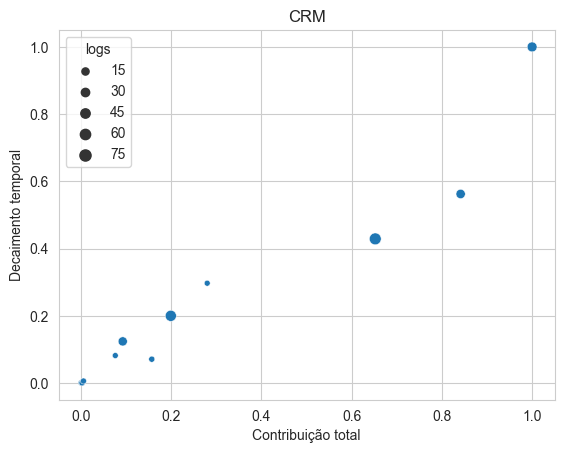

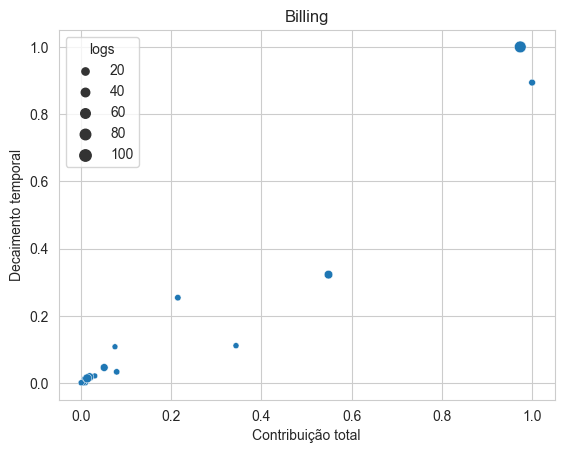

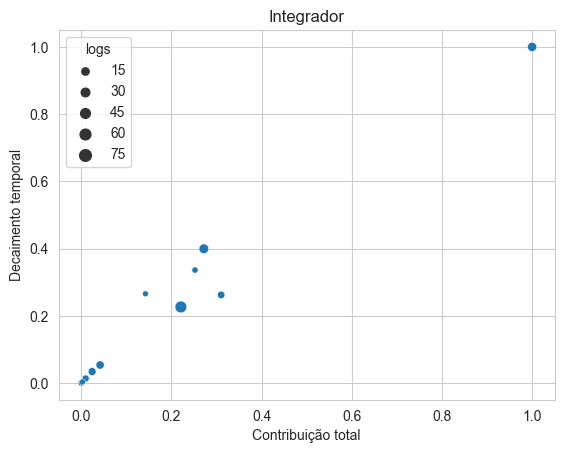

In [ ]:
#@title Análise Grafica por Factor de decaimento
# (Contribuição total x Decaimento temporal x Logs) por Colaborador
def generate_scatterplot_factor(data, tittle):
    # Extrair os valores das variáveis para o gráfico
    normalization_total = [obj['normalizationTotal'] for obj in data]
    normalization_factor = [obj['normalizationFactor'] for obj in data]
    logs = [obj['logs'] for obj in data]

    # Criar o DataFrame com os dados
    df = pd.DataFrame({
        'Contribuição total': normalization_total,
        'Decaimento temporal': normalization_factor,
        'logs': logs
    })

    # Gerar o gráfico de dispersão
    sns.set_style("whitegrid")
    sns.scatterplot(data=df, x='Contribuição total', y='Decaimento temporal', size='logs')

    # Exibir o gráfico
    plt.title(tittle)
    plt.show()

for data in sectorLogs:
    generate_scatterplot_factor(data["userLogs"], data["sector"])

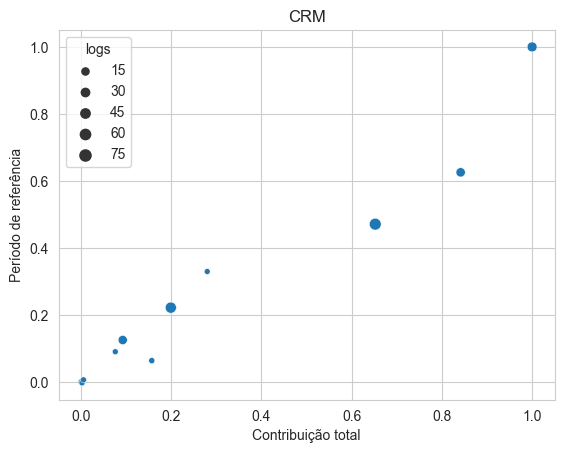

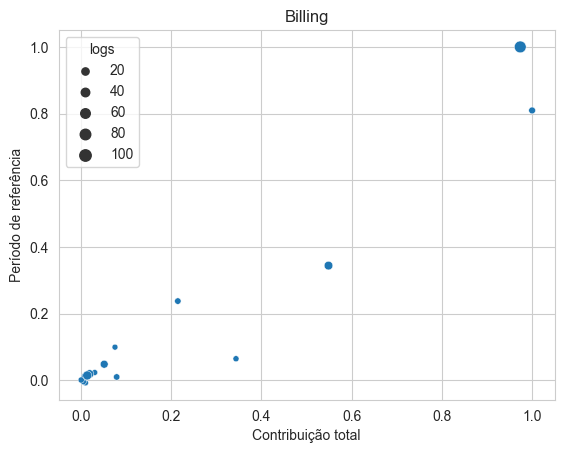

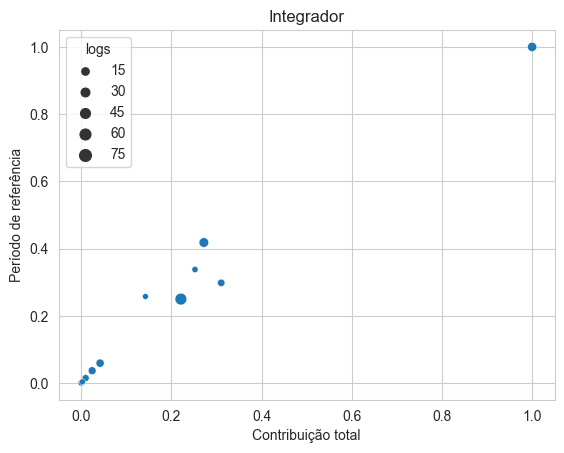

In [ ]:
#@title Análise Grafica por Periodo de referencia
# (Contribuição total x Decaimento temporal x Logs) por Colaborador
def generate_scatterplot_period(data, tittle):
    # Extrair os valores das variáveis para o gráfico
    normalization_total = [obj['normalizationTotal'] for obj in data]
    normalization_period = [obj['normalizationPeriod'] for obj in data]
    logs = [obj['logs'] for obj in data]

    # Criar o DataFrame com os dados
    df = pd.DataFrame({
        'Contribuição total': normalization_total,
        'Período de referência': normalization_period,
        'logs': logs
    })

    # Gerar o gráfico de dispersão
    sns.set_style("whitegrid")
    sns.scatterplot(data=df, x='Contribuição total', y='Período de referência', size='logs')

    # Exibir o gráfico
    plt.title(tittle)
    plt.show()

for data in sectorLogs:
    generate_scatterplot_period(data["userLogs"], data["sector"])

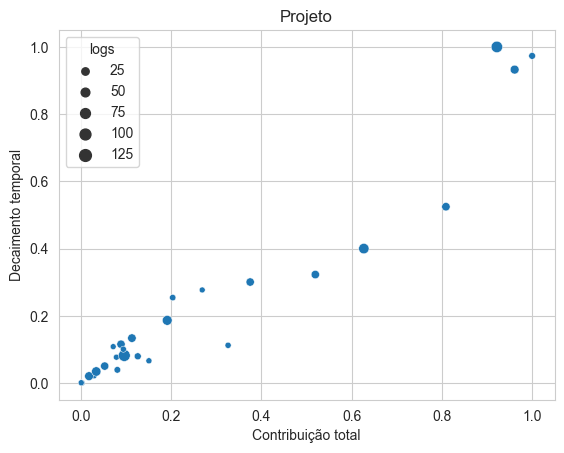

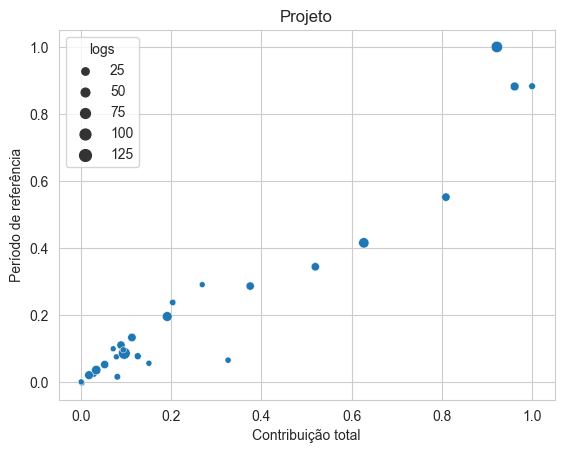

{'_protected': False,
 '_class': {'_id': '6348b342766093172755bb39',
  '_classId': '000000000000000000000000'},
 'sector': 'Sumicity',
 'totalLogs': None,
 '_creationDate': '2023-06-22T04:03:08.340Z',
 '_creationUser': {'_id': '62a9e6b8ae42db5788c58bdf',
  '_classId': '000000000000000000000002'},
 'userLogs': [{'normalizationTotal': 0.9219468628187688,
   'normalizationFactor': 1.0,
   'normalizationPeriod': 1.0,
   '_class': {'_id': '6348aa069e06846d855bf19a',
    '_classId': '000000000000000000000000'},
   'sector': None,
   'contributionFactor': 691310,
   'userId': {'_id': '628257a40ce07f1bfcb40779',
    '_classId': '000000000000000000000002'},
   'contributionPeriod': 773717,
   '_id': '6493c7fc42afe93e6c56f690',
   'logs': 114,
   '_classRevision': '93a53ae576a3e60c8e400c41c537f174',
   'contributionTotal': 1028145},
  {'normalizationTotal': 1.0,
   'normalizationFactor': 0.9732753757359217,
   'normalizationPeriod': 0.8828861198603624,
   '_class': {'_id': '6348aa069e06846d855bf

In [ ]:
def generate_table(data):
    if data:  # Verifica se a lista não está vazia
        header = data[0].keys()  # Extrai as chaves do primeiro dicionário
        table = tabulate(data, headers=header)
        print(table)
    else:
        print("A lista de dados está vazia.")

normalize_objects(globalUsersLogs)
generate_scatterplot_factor(globalUsersLogs, "Projeto")
generate_scatterplot_period(globalUsersLogs, "Projeto")

payload = {
    "sector": "Sumicity",
    "userLogs": globalUsersLogs
}

requestSydle("createSectorStats", payload)
time.sleep(0.2)

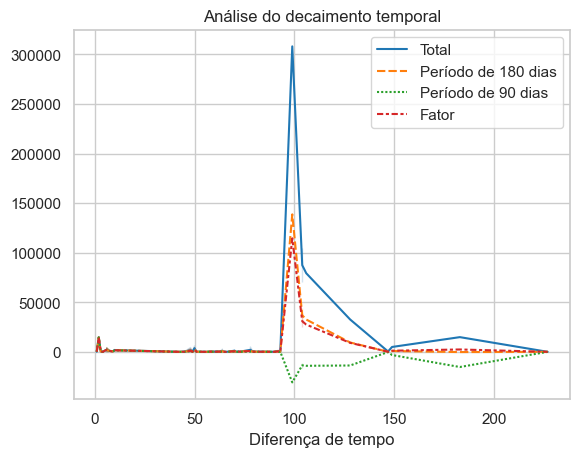

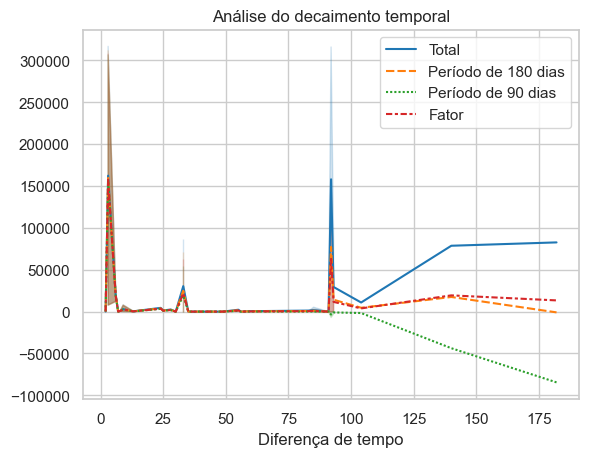

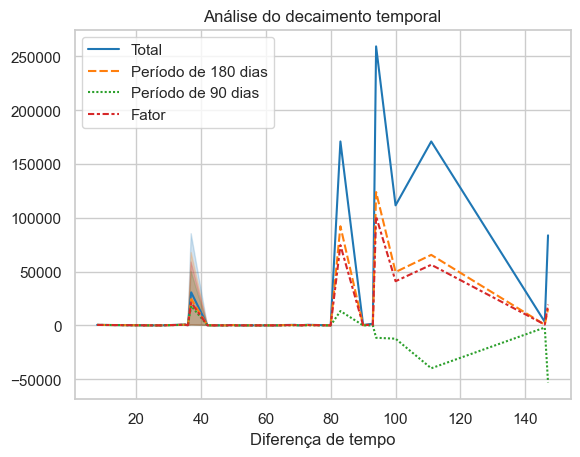

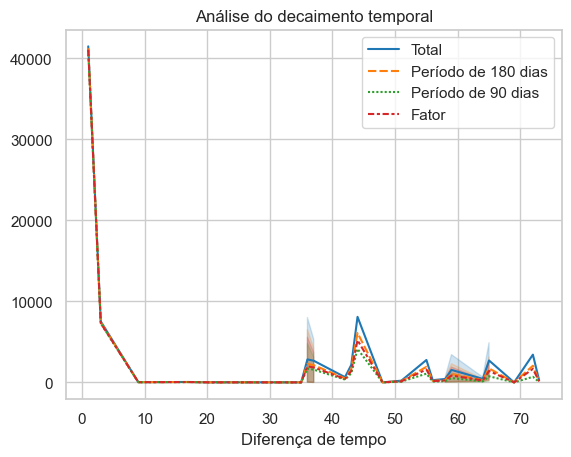

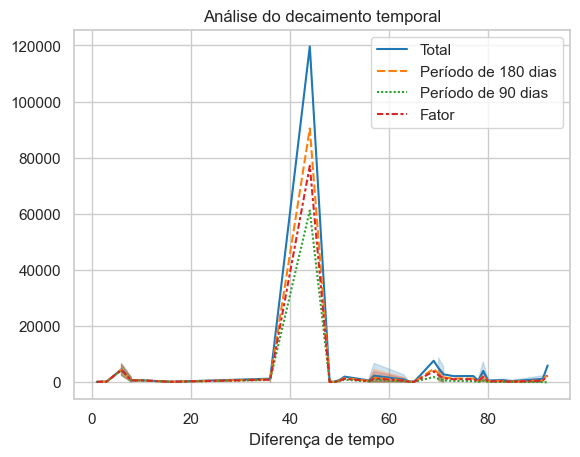

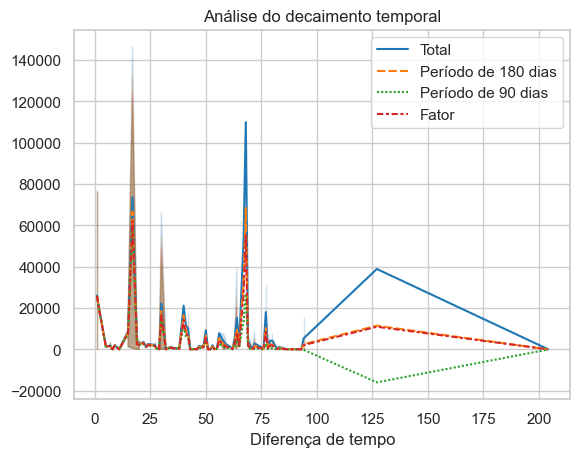

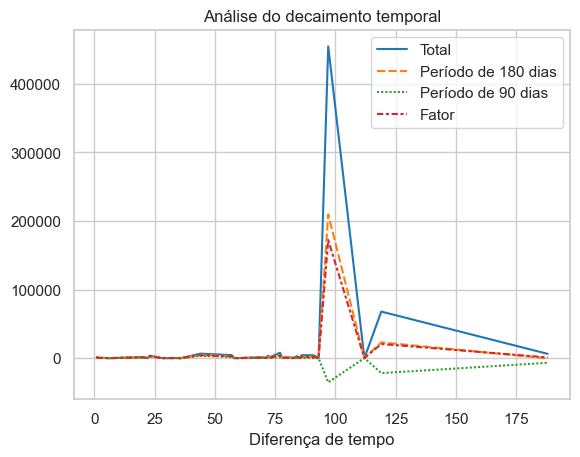

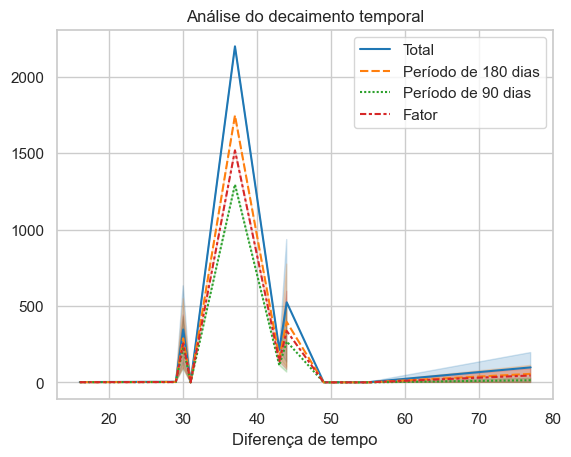

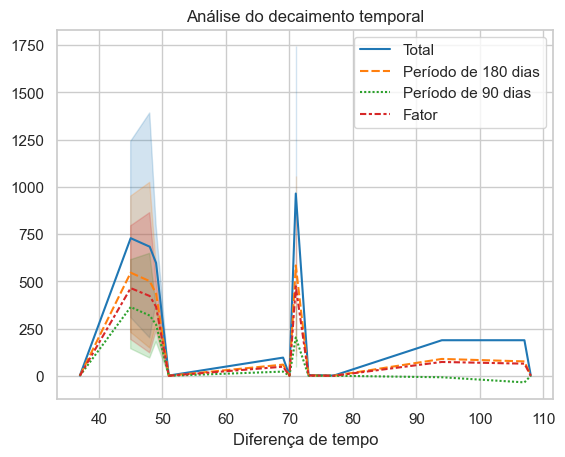

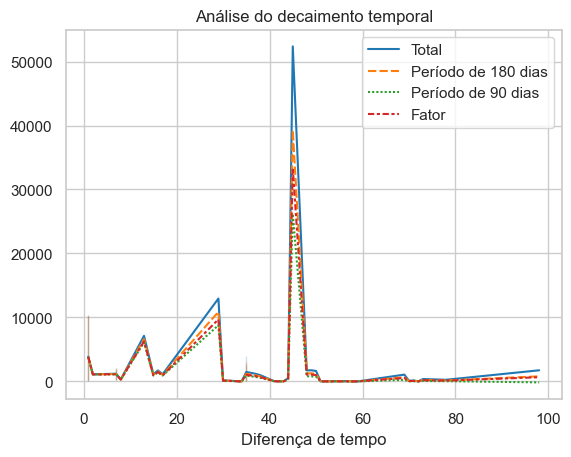

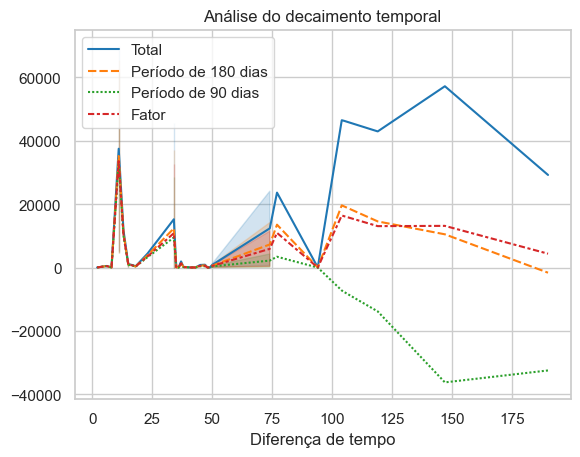

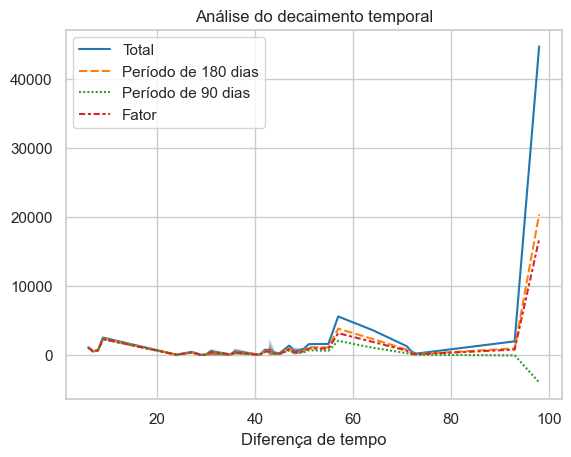

In [ ]:
def lineplot_graph(data, tittle):
    time_diff = [obj['timeDiff'] for obj in data]
    contribution_total = [obj['contributionTotal'] for obj in data]
    contribution_period = [obj['contributionPeriod'] for obj in data]
    contribution_period2 = [obj['contributionPeriod2'] for obj in data]
    contribution_factor = [obj['contributionFactor'] for obj in data]
    data_dict = {
        'Diferença de tempo': time_diff,
        'Total': contribution_total,
        'Período de 180 dias': contribution_period,
        'Período de 90 dias': contribution_period2,
        'Fator': contribution_factor
    }
    data_df = pd.DataFrame(data_dict)
    data_df.set_index('Diferença de tempo', inplace=True)
    data_df = data_df.rolling(1).mean()
    sns.set_theme(style="whitegrid")
    sns.lineplot(data=data_df, palette="tab10", linewidth=1.5)
    plt.title(tittle)
    plt.show()
    

indexUser = next((index for index, user in enumerate(logsHistory) if user["userId"] == "61533916ecd6e51095726039"), -1)
for data in logsHistory:
    if len(data["logsHistory"]) > 40:
        lineplot_graph(data["logsHistory"], "Análise do decaimento temporal")

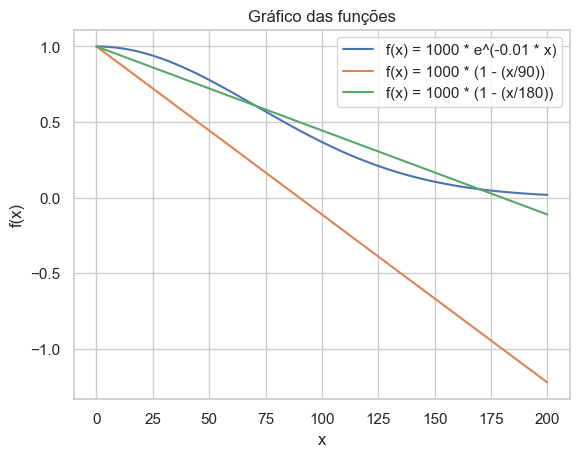

In [ ]:
x = np.linspace(0, 200, 1000)  # Faixa de valores de x
y1 = np.exp(-0.0001 * x**2)  # Avaliação da função f(x)
y2 = (1 - (x / 90))  # Avaliação da função f(x) = 1000 * (1 - (x/90))
y3 = (1 - (x / 180))  # Avaliação da função f(x) = 1000 * (1 - (x/180))

plt.plot(x, y1, label='f(x) = 1000 * e^(-0.01 * x)')
plt.plot(x, y2, label='f(x) = 1000 * (1 - (x/90))')
plt.plot(x, y3, label='f(x) = 1000 * (1 - (x/180))')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gráfico das funções')
plt.grid(True)
plt.legend()
plt.show()